In [1]:
# Created 05/13/19 by A.T. (tropiano.4@osu.edu)

# This notebook makes a momentum projection operator figure for a NUCLEI highlight.

from os import chdir, getcwd
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.linalg import expm
# Scripts made by A.T.
from deuteron import Deuteron
from Figures import figures_functions as ff
from Potentials.vsrg_macos import load_save_potentials as lp
from SRG_codes.srg_unitary_transformation import SRG_unitary_transformation

__Function for plotting momentum projection operators evolving in $\lambda$__

In [2]:
def momentum_projection_operator(q, kvnn, channel, kmax, kmid, ntot, method, generator, lambda_bd=0.00, \
                                 k_magnus=6, ds=1e-5):
    '''Plots a 2 x 2 figure of the momentum projection operator evolving from 10.0 to 1.2 fm^-1.'''
    
    # Arguments
    
    # q (float): Momentum value in fm^-1
    # kvnn (integer): This number specifies the potential
    # channel (string): The partial wave channel ('1S0', '3S1', etc.)
    # kmax (float): Maximum value in the momentum mesh
    # kmid (float): Mid-point value in the momentum mesh
    # ntot (integer): Number of momentum points in mesh
    # method (string): The evolution method 'srg' or 'magnus'
    # generator (string): SRG generator ('Wegner', 'T', 'Block-diag')
    # lambda_bd (float): Lambda value for block-diagonal decoupling (e.g. 2.00 fm^-1)
    # k_magnus (integer): Number of terms to include in Magnus sum (for Magnus only)
    # ds (float): Step-size in the flow parameter s (for Magnus only)
    
    # Current working directory
    cwd = getcwd()
    
    # Limits of axes on contours (units are fm^-1)
    axes_max = 4.0
    
    # Load initial Hamiltonian, momentum, and weights
    H0_matrix = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot)
    gp, gw = lp.load_momentum(kvnn, channel, kmax, kmid, ntot)
    # The arrays below are used later to present a mesh-independent result 
    row, col = np.meshgrid(gp*np.sqrt(gw), gp*np.sqrt(gw))
    
    # Pick the nearest value of q if q isn't exactly in gp
    if not( q in gp ):
        
        k_difference_array = abs(gp-q)
        k_difference_min = min(k_difference_array)
        q_index = list(k_difference_array).index(k_difference_min)
        # Reset q to an actual value in k_array mesh (this is the closest value to entered q)
        q = gp[q_index]    
    
    # Initialize deuteron class 
    D = Deuteron(H0_matrix, gp, gw)
    
    # Loop over lambda values in lambdas and save evolved operators to dictionary where key = lambda
    lambdas = [10.0, 2.8, 2.0, 1.2]
    d = {}
    
    for lamb in lambdas:
        
        # Load unitary transformation
        # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
        if method == 'srg':
            
            # Must input evolved matrix
            Hs_matrix = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, method, generator, lamb, lambda_bd)
            Us_matrix = SRG_unitary_transformation(H0_matrix, Hs_matrix)
            
        # Magnus loads Omega(s) to compute U(s) = exp^Omega(s)
        elif method == 'magnus':
            
            # Switch to step-size of 1e-6 (or smaller) automatically if lambda = 10 fm^-1
            if lamb == 10.0 and ds > 1e-6:
                step_size = 1e-6
            else:
                step_size = ds
            
            Os_matrix = lp.load_omega(kvnn, channel, kmax, kmid, ntot, generator, lamb, lambda_bd, k_magnus, \
                                      step_size)
            Us_matrix = expm(Os_matrix)
        
        # Evolved momentum projection operator in 3S1 channel divided by k_i * k_j * sqrt( w_i * w_j ) 
        # for mesh-independent result
        momentum_proj_operator = D.momentum_proj_operator(q, U=Us_matrix)[:120,:120]/row/col
        
        # Interpolate the operator for better looking figure
        k_array, interpolated_operator = ff.interpolate_matrix(gp, momentum_proj_operator, axes_max)
        # Enter into dictionary
        d[lamb] = interpolated_operator
    
    # Limits of color bar in fm
    mx = 0.005
    mn = -0.005
    
    # Color scheme for contour plots
    color_style = 'jet'
        
    # Location of labels
    if q < axes_max/2:
        q_loc = 7
        lamb_loc = 3
    else:
        q_loc = 2
        lamb_loc = 3
        
    # Step-size in labeling tick marks
    stepsize = 1.0
    
    # Plot 2 x 2 figure     
    plt.close('all')
    
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(11,10))
    
    # lambda = 10.0 fm^-1
    ax1.pcolormesh(k_array, k_array, d[lambdas[0]], vmin=mn, vmax=mx, cmap=color_style)
    ax1.set_xlim([0,axes_max])
    ax1.set_ylim([0,axes_max])
    ax1.set_xlabel(r"$k \/ \/ [fm^{-1}]$", fontsize=16)
    ax1.set_ylabel(r"$k' \/ \/ [fm^{-1}]$", fontsize=16)
    ax1.xaxis.set_ticks(np.arange(0.0, axes_max+stepsize, stepsize))
    ax1.yaxis.set_ticks(np.arange(0.0, axes_max+stepsize, stepsize))
    ax1.xaxis.set_label_position('top')
    ax1.xaxis.tick_top()
    ax1.tick_params(labeltop=True)
    anchored_text_1 = AnchoredText(r'$q=%.2f\/fm^{-1}$'%q, prop=dict(size=20), loc=q_loc, frameon=False)
    ax1.add_artist(anchored_text_1)
    anchored_text_2 = AnchoredText(r'$\lambda=%.1f\/fm^{-1}$'%lambdas[0], prop=dict(size=20), loc=lamb_loc, \
                                   frameon=False)
    ax1.add_artist(anchored_text_2)
    
    # lambda = 2.8 fm^-1
    ax2.pcolormesh(k_array, k_array, d[lambdas[1]], vmin=mn, vmax=mx, cmap=color_style)
    ax2.set_xlim([0,axes_max])
    ax2.set_ylim([0,axes_max])
    ax2.set_xlabel(r"$k \/ \/ [fm^{-1}]$", fontsize=16)
    ax2.xaxis.set_ticks(np.arange(0.0, axes_max+stepsize, stepsize))
    ax2.yaxis.set_ticks(np.arange(0.0, axes_max+stepsize, stepsize))
    ax2.xaxis.set_label_position('top')
    ax2.xaxis.tick_top()
    ax2.tick_params(labeltop=True)
    anchored_text_3 = AnchoredText(r'$\lambda=%.1f\/fm^{-1}$'%lambdas[1], prop=dict(size=20), loc=lamb_loc, \
                                   frameon=False)
    ax2.add_artist(anchored_text_3)
    
    # lambda = 2.0 fm^-1
    ax3.pcolormesh(k_array, k_array, d[lambdas[2]], vmin=mn, vmax=mx, cmap=color_style)
    ax3.set_xlim([0,axes_max])
    ax3.set_ylim([0,axes_max])
    ax3.set_ylabel(r"$k \/ \/ [fm^{-1}]$", fontsize=16)
    ax3.xaxis.set_ticks(np.arange(0.0, axes_max+stepsize, stepsize))
    ax3.yaxis.set_ticks(np.arange(0.0, axes_max+stepsize, stepsize))
    ax3.xaxis.tick_top()
    ax3.tick_params(labeltop=False)
    anchored_text_4 = AnchoredText(r'$\lambda=%.1f\/fm^{-1}$'%lambdas[2], prop=dict(size=20), loc=lamb_loc, \
                                   frameon=False)
    ax3.add_artist(anchored_text_4)

    # lambda = 1.2 fm^-1
    c = ax4.pcolormesh(k_array, k_array, d[lambdas[3]], vmin=mn, vmax=mx, cmap=color_style)
    ax4.set_xlim([0,axes_max])
    ax4.set_ylim([0,axes_max])
    ax4.xaxis.set_ticks(np.arange(0.0, axes_max+stepsize, stepsize))
    ax4.yaxis.set_ticks(np.arange(0.0, axes_max+stepsize, stepsize))
    ax4.xaxis.tick_top()
    ax4.tick_params(labeltop=False)
    anchored_text_5 = AnchoredText(r'$\lambda=%.1f\/fm^{-1}$'%lambdas[3], prop=dict(size=20), loc=lamb_loc, \
                                   frameon=False)
    ax4.add_artist(anchored_text_5)

    plt.gca().invert_yaxis()
    f.subplots_adjust(hspace=0.1, wspace=0.1)
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
    cbar = f.colorbar(c, cax=cbar_ax)
    # What are the units??
    #cbar.set_label(r'$[fm^6]$', rotation=0, labelpad=25, fontsize=18)
    
    # Name of jpeg file
    q_string = 'q%.2f'%q
    q_string = q_string[:2]+','+q_string[3:]
    name = 'momentum_projection_operator_%s_kvnn%s_%s_%s_%s'%(q_string, kvnn, channel, method, generator) 
        
    # Save figure
    folder = ff.current_date() # Gets current month and year
    chdir('Figures/%s'%folder)
    f.savefig(name+'.jpg',bbox_inches='tight')
    chdir(cwd)      

__Run function in the cell below__

In [3]:
# Specifications for potential and evolution method

# Wendt non-local LO chiral potential at Lambda = 4 fm^-1
kvnn = 10
channel = '3S1'
kmax = 30.0
kmid = 4.0
ntot = 120

# Magnus evolved
method = 'magnus'
generator = 'Wegner'
k_magnus = 6
ds = 1e-6

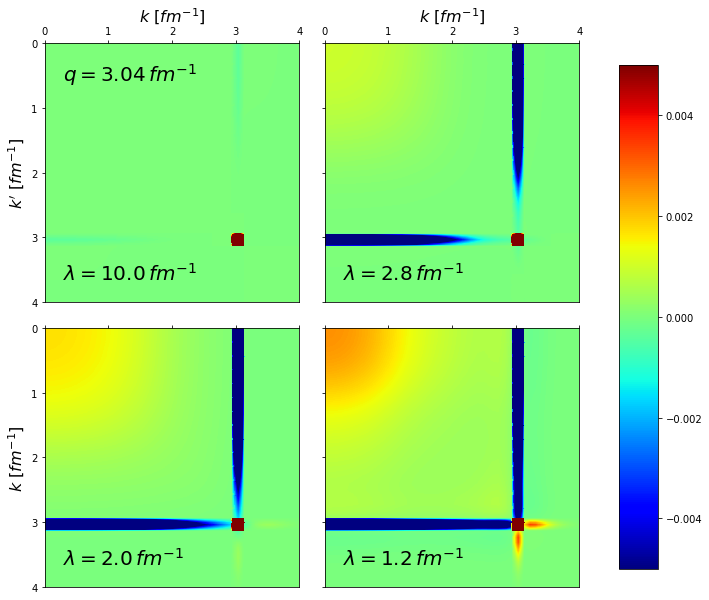

In [4]:
# Plot the figure

q = 3.0
momentum_projection_operator(q, kvnn, channel, kmax, kmid, ntot, method, generator, k_magnus=k_magnus, ds=ds)